In [2]:
%matplotlib notebook
# build a simple rnn with cleaned test data to predict close price
# step1: import modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import os
import math

In [3]:
from clean_data import clean_csv_data
stock_code = '600000'
df = clean_csv_data(stock_code + '.csv')
df

,date,close,rise
1,20200221,10.70,0.006585
2,20200224,10.56,-0.013084
3,20200225,10.49,-0.006629
4,20200226,10.60,0.010486
5,20200227,10.61,0.000943
...,...,...,...
249,20210301,10.58,0.003795
250,20210302,10.47,-0.010397
251,20210303,10.92,0.042980
252,20210304,10.88,-0.003663


In [4]:
# step2: 制定训练集和测试集
# 总数据集大小
data_sz = df.shape[0]
# 计算测试集大小, 约为原数据的%20. 向上取整
test_set_sz = math.ceil(data_sz * 0.2)
training_set_sz = data_sz - test_set_sz
# 前(data_sz - test_set_sz)天的涨幅作为训练集, 后test_set_sz天的涨幅作为测试集
training_set = df.iloc[0:training_set_sz, 1:2].values
test_set = df.iloc[-test_set_sz:, 1:2]

In [5]:
# 数据归一化到(0,1)之间
sc = MinMaxScaler(feature_range=(0, 1))
# 求得训练集的最大值，最小值这些训练集固有的属性，并在训练集上进行归一化
training_set_scaled = sc.fit_transform(training_set) 
test_set = sc.transform(test_set)  # 利用训练集的属性对测试集进行归一化

In [6]:
x_train = []
y_train = []

x_test = []
y_test = []
sample_sz = 10

In [7]:
# 利用for循环，遍历整个训练集，提取训练集中连续sample_sz=15天的开盘价作为输入特征x_train，
# 第16天的数据作为标签，for循环共构建training_set_sz-15组数据。
for i in range(sample_sz, len(training_set_scaled)):
    x_train.append(training_set_scaled[i - sample_sz:i, 0])
    y_train.append(training_set_scaled[i, 0])
# 对训练集进行打乱
np.random.seed(56)
np.random.shuffle(x_train)
np.random.seed(56)
np.random.shuffle(y_train)
tf.random.set_seed(56)
# 将训练集由list格式变为array格式
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
# RNN输入：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]
# 此处整个数据集送入，送入样本数为x_train.shape[0]组数据；输入sample_sz个开盘价，预测出第sample_sz+1天的开盘价，
# 循环核时间展开步数为sample_sz; 每个时间步送入的特征是某一天的开盘价，只有1个数据，故每个时间步输入特征个数为1
x_train = np.reshape(x_train, (x_train.shape[0], sample_sz, 1))
# 测试集
for i in range(sample_sz, test_set_sz):
    x_test.append(test_set[i - sample_sz:i, 0])
    y_test.append(test_set[i, 0])
# 测试集变array并reshape为符合RNN输入要求
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], sample_sz, 1))

In [9]:
# step3: 逐层搭建网络结构
model = tf.keras.Sequential([
    SimpleRNN(80, return_sequences=True),
    Dropout(0.2),
    SimpleRNN(100),
    Dropout(0.2),
    Dense(1)
])

In [10]:
# step4: 在 model.compile()中配置训练方法，选择训练时使用的优化器、损失函数和最终评价指标。
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mean_squared_error')  # 损失函数用均方误差
# 该应用只观测loss数值，不观测准确率，所以删去metrics选项

In [11]:
# 存取模型(断点续训)
# 读取模型
checkpoint_save_path = "./checkpoint/stock_close_price_pred_SimpleRNN.ckpt"

if os.path.exists(checkpoint_save_path + '.index'):
    print('-------------load the model-----------------')
    model.load_weights(checkpoint_save_path)

# 保存模型
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor='val_loss')

history = model.fit(x_train, y_train, batch_size=4, epochs=50, validation_data=(x_test, y_test), validation_freq=1,
                    callbacks=[cp_callback])

model.summary()

-------------load the model-----------------
Train on 192 samples, validate on 41 samples
Epoch 1/50
192/192 [==============================] - 3s 15ms/sample - loss: 0.0085 - val_loss: 0.0082
Epoch 2/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0086 - val_loss: 0.0127
Epoch 3/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0076 - val_loss: 0.0086
Epoch 4/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0108 - val_loss: 0.0081
Epoch 5/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0103 - val_loss: 0.0052
Epoch 6/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0106 - val_loss: 0.0064
Epoch 7/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0086 - val_loss: 0.0065
Epoch 8/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0079 - val_loss: 0.0058
Epoch 9/50
192/192 [==============================] - 0s 2ms/sample - loss: 0.0081 - val_loss

In [12]:
# 参数提取存入文本
file = open('./weights/stock_close_price_pred_SimpleRNN_weights.txt', 'w')  
for v in model.trainable_variables:
    file.write(str(v.name) + '\n')
    file.write(str(v.shape) + '\n')
    file.write(str(v.numpy()) + '\n')
file.close()

<IPython.core.display.Javascript object>


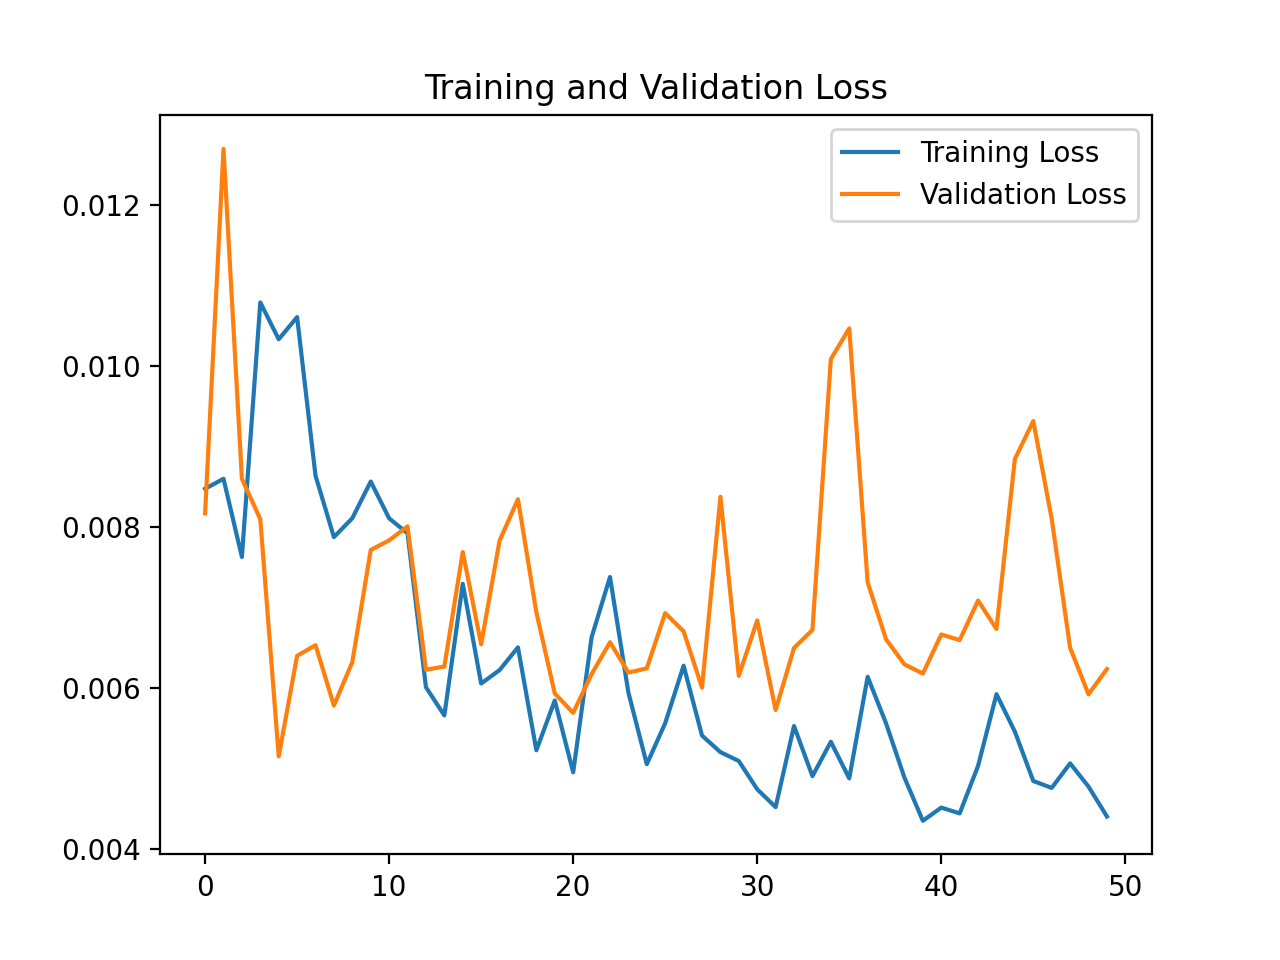

In [13]:
# loss 可视化
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
plt.savefig('RNN_Close_Price_Loss.png')

<IPython.core.display.Javascript object>


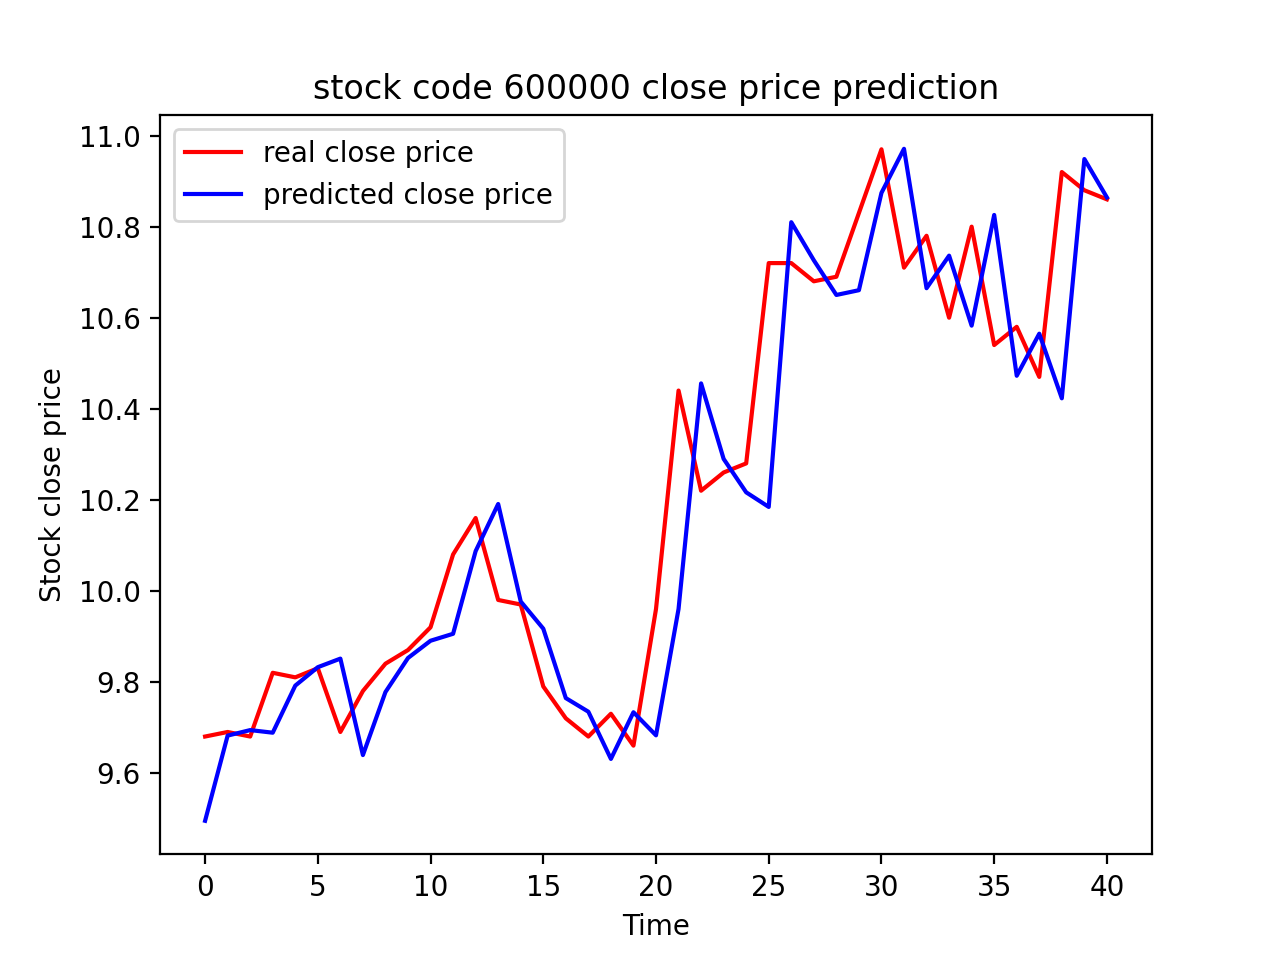

In [14]:
# 预测
# 测试集输入模型进行预测
predicted_stock_cl_price = model.predict(x_test)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_stock_cl_price = sc.inverse_transform(predicted_stock_cl_price)
# 对真实数据还原---从（0，1）反归一化到原始范围
real_stock_cl_price = sc.inverse_transform(test_set[sample_sz:])
# 画出真实数据和预测数据的对比曲线
plt.figure(2)
plt.plot(real_stock_cl_price, color='red', label='real close price')
plt.plot(predicted_stock_cl_price, color='blue', label='predicted close price')
plt.title('stock code '+stock_code + ' close price prediction')
plt.xlabel('Time')
plt.ylabel('Stock close price')
plt.legend()
plt.show()
plt.savefig('RNN_Close_Price_Pridiction.png')